<h1>Caesarean Section Prediction Using Machine Learning</h1>


# I) Introduction

Caesarean Section surgeries are known to be life-saving for both the mother and the child. However, they are not recommended if vaginal delivery is possible and doesn’t jeopardize the health of the foetus nor his mother. A study has shown that the risk of a woman/a child dying from cesarean section is so much higher than that from vaginal delivery. This confirms how important it is for medical entities to choose whether or not to perform C-section, a decision as costly and hazardous as any other medical surgery.
We aim with this project to use machine learning methods and techniques to predict which decision is best.We explain further in this report the methods we’ve implemented as well as some data processing techniques.

In [1]:
#Imports

import csv
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score

# II)Data Preprocessing

 We will first start with transforming the 552 "*.hea" files into a unique .csv file containing all our Dataset.


In [2]:
with open('dataset.csv','w',newline='') as f:
   
    thewriter=csv.writer(f)    
    thewriter.writerow(['pH','BDecF','pCO2','BE','Apgar1','Apgar5','Gest. weeks','Weight','Sex','Age','Gravidity',
    'Parity', 'Diabetes','Hypertension','Preeclampsia','Liq.praecox','Pyrexia', 'Meconium','Deliv. type'])

#Manual selection of the values for each attributes and for each sample
    
    for i in range(1001,1507):
        
        ch=str(i)
    
        sig, fields = wfdb.srdsamp('/home/rostom/Downloads/ctu-chb-intrapartum-cardiotocography-database-1.0.0/'
        +ch, sampfrom=800)
        temp=fields['comments']
    
        listt=[temp[2][4:],temp[3][6:],temp[4][6:],temp[5][8:],temp[6][8:],temp[7][8:],temp[16][12:],
        temp[17][12:],temp[18][6:],temp[20][6:],temp[21][11:],temp[22][11:],temp[23][10:],temp[24][12:],
        temp[25][12:],temp[26][12:],temp[27][10:],temp[28][9:],temp[36][11:]]
        
        for j in range(len(listt)):            
                listt[j]=float(listt[j])
        
        thewriter.writerow(listt)
    
    for i in range(2001,2047):
        ch=str(i)
    
        sig, fields = wfdb.srdsamp('/home/rostom/Downloads/ctu-chb-intrapartum-cardiotocography-database-1.0.0/'
        +ch, sampfrom=800)
        temp=fields['comments']
    
        listt=[temp[2][4:],temp[3][6:],temp[4][6:],temp[5][8:],temp[6][8:],temp[7][8:],temp[16][12:],
        temp[17][12:],temp[18][6:],temp[20][6:],temp[21][11:],temp[22][11:],temp[23][10:],temp[24][12:],
        temp[25][12:],temp[26][12:],temp[27][10:],temp[28][9:],temp[36][11:]]
        
        for j in range(len(listt)):           
                listt[j]=float(listt[j])
        
        thewriter.writerow(listt)
   
    
    

In [3]:
#DataFrame creation

data=pd.read_csv('/home/rostom/Downloads/dataset.csv')
data.head(5)




,pH,BDecF,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight,Sex,Age,Gravidity,Parity,Diabetes,Hypertension,Preeclampsia,Liq.praecox,Pyrexia,Meconium,Deliv. type
0,7.14,8.14,7.7,-10.5,6.0,8.0,37.0,2660.0,2.0,32.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,7.00,7.92,12.0,-12.0,8.0,8.0,41.0,2900.0,2.0,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,7.20,3.03,8.3,-5.6,7.0,9.0,40.0,3770.0,1.0,31.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,7.30,5.19,5.5,-6.4,8.0,9.0,41.0,3370.0,1.0,36.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,7.30,4.52,5.7,-5.8,9.0,10.0,41.0,3550.0,2.0,28.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 1) Dealing with NaN values


For different reasons, many samples of our DataSet contain NaN values for some critical features. That's why we are considering two possible solutions:
 - Removing sbjects with NaN values
 - Imputation : replacing missing values with subtitute values.


In [4]:
### removing subjects with nan values

lines = list()

with open('/home/rostom/Downloads/dataset.csv', 'r') as readFile:

    reader = csv.reader(readFile)

    for row in reader:
        test=True
        for field in row:        

            if field =='nan': 
                test=False
        if test==True:
            lines.append(row)
        

with open('/home/rostom/Downloads/dataset1.csv', 'w') as writeFile:

    writer = csv.writer(writeFile)
    writer.writerows(lines)

In [5]:
#Creation of the corresponding DataFrame

data1=pd.read_csv('/home/rostom/Downloads/dataset1.csv')




Before the imputation, we decided to go deeper into the correlation between features in order to have a better idea about the most appropriate imputation that can be done:


<AxesSubplot:title={'center':'Correlation of Features'}>

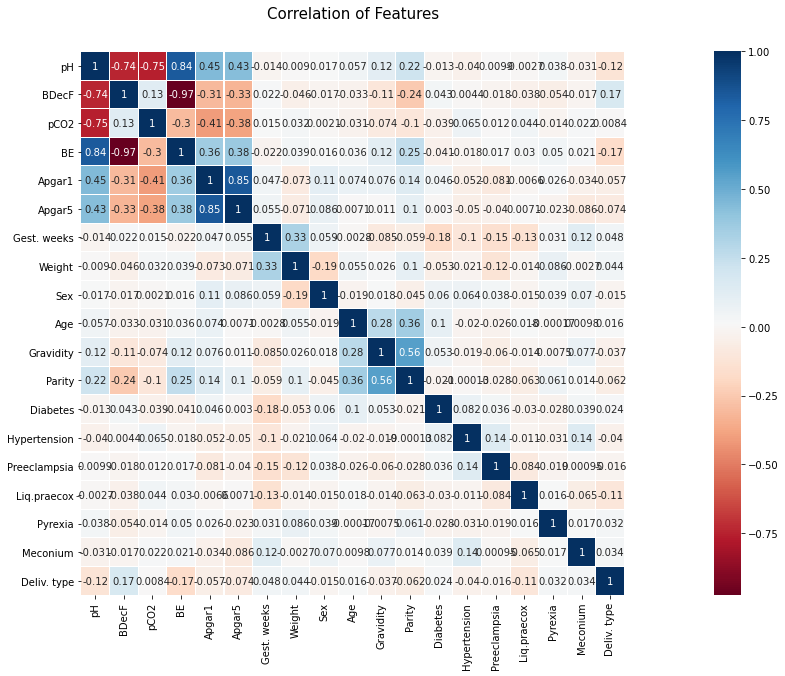

In [6]:
#Matrix of Correlation of Features

data_selected = data[['pH','BDecF','pCO2','BE','Apgar1','Apgar5','Gest. weeks','Weight','Sex','Age','Gravidity',
    'Parity', 'Diabetes','Hypertension','Preeclampsia','Liq.praecox','Pyrexia', 'Meconium','Deliv. type']].copy()
colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(data_selected.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

The most features with NaN values in out Dataset are the 'pH', 'BDecF' and 'BE'. These features have a good correlation factor with the Delivery Type (-0.12, 0.17 and -0.17 respectively). In order to respect the correlation between these features, we decided to replace the NaN values of these features with the median of the values of that feature BUT for the same Delivery Type.
For example : if a women who got a Ceasarean delivery is missing the 'BE' feature, we will replace it with the median of all the 'BE' values of all the women who got a Ceasarean delivery.

In [7]:
#Imputation
lines=list()

with open('/home/rostom/Downloads/dataset.csv', 'r') as readFile:
    
    data_vaginal=data.head(506)
    data_ceasarean=data1[506:]
    
    
    reader = csv.reader(readFile)
    list_attributes=['pH','BDecF','pCO2','BE','Apgar1','Apgar5','Gest. weeks','Weight','Sex','Age',
    'Gravidity','Parity', 'Diabetes','Hypertension','Preeclampsia','Liq.praecox','Pyrexia', 'Meconium','Deliv. type']
    j=0
    for row in reader:
        j+=1
        test=True
        i=-1
        for field in row:
            i+=1                 
            if field =='nan':
                if j<=506:
                    row[row.index(field)]=data_vaginal[list_attributes[i]].median()
                else:
                    row[row.index(field)]=data_ceasarean[list_attributes[i]].median()
                
        lines.append(row)
        

with open('/home/rostom/Downloads/dataset2.csv', 'w') as writeFile:

    writer = csv.writer(writeFile)
    writer.writerows(lines)

In [8]:
#Creation of the corresponding DataFrame

data2=pd.read_csv('/home/rostom/Downloads/dataset2.csv')



For the rest of the project, we will work with this version of the DataSet (NaN values replaced by the median values of the corresponding classes).

# 2) Dealing with imbalanced Data

In [9]:
#Repartition of Input and Output

X=data2.drop(['Deliv. type'],axis=1)
Y=data2['Deliv. type'].copy()


Our Dataset contains 552 samples : 506 of them represent the Ceasarean Delivery class (>91%) and only 44 of them represent the Vaginal Delivery class (<8%). This imbalance may cause insatisfactory predictions after the training. In order to avoid such risks, we are considering 3 possible ways to deal with the problem:
   - Work with the original Imbalanced DataSet.
   - Oversample the original Imbalanced Dataset.
   - Undersample the original Imbalanced Dataset.

In [10]:
#Oversampling


oversample = SMOTE()
X1, Y1 = oversample.fit_resample(X, Y)

#Undersampling


undersample = NearMiss(version=1)
X2, Y2 = undersample.fit_resample(X, Y)




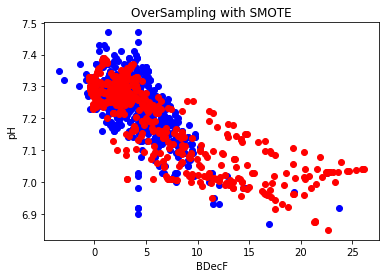

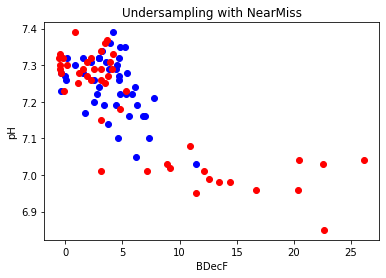

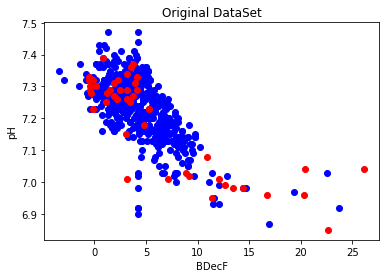

In [11]:
#Plotting of the repartition of the 3 Datasets 

x1=list(X1['BDecF'])[:507]
x2=list(X1['BDecF'])[507:]
y1=list(X1['pH'])[:507]
y2=list(X1['pH'])[507:]

plt.xlabel('BDecF')
plt.ylabel('pH')
plt.title('OverSampling with SMOTE')
plt.plot(x1, y1, 'bo')
plt.plot(x2, y2, 'ro')
plt.show()


x1=list(X2['BDecF'])[:46]
x2=list(X2['BDecF'])[46:]
y1=list(X2['pH'])[:46]
y2=list(X2['pH'])[46:]

plt.xlabel('BDecF')
plt.ylabel('pH')
plt.title('Undersampling with NearMiss')
plt.plot(x1, y1, 'bo')
plt.plot(x2, y2, 'ro')
plt.show()



x1=list(data2['BDecF'])[:507]
x2=list(data2['BDecF'])[507:]
y1=list(data2['pH'])[:507]
y2=list(data2['pH'])[507:]

plt.xlabel('BDecF')
plt.ylabel('pH')
plt.title('Original DataSet')
plt.plot(x1, y1, 'bo')
plt.plot(x2, y2, 'ro')
plt.show()

# 3) Selection of the final Dataset

We are going to train a simple linear classifier with the 3 different Datasets in order to keep only the Dataset giving the best Model. We will train a Logistic Regression Classifier.

In [12]:
#Split to training and testing sets for the 3 Datasets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2) 
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,Y1, test_size=0.2) 
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,Y2, test_size=0.2) 

In [13]:
#logistic regression over Imbalanced Dataset

regr=LogisticRegression()
regr.fit(X_train,y_train)
Y_hat=regr.predict(X_test)
Imbalanced= metrics.accuracy_score(y_test,Y_hat)

#logistic regression over OverSampled Dataset

regr=LogisticRegression()
regr.fit(X1_train,y1_train)
Y_hat=regr.predict(X1_test)
Oversampled= metrics.accuracy_score(y1_test,Y_hat)


#logistic regression over UnderSampled Dataset

regr=LogisticRegression()
regr.fit(X2_train,y2_train)
Y_hat=regr.predict(X2_test)
Undersampled= metrics.accuracy_score(y2_test,Y_hat)

print (" Accuracy for Imbalanced Dataset testing : ",Imbalanced, '\n',
       "Accuracy for OverSampled Dataset testing : ",Oversampled, '\n',
       "Accuracy for UnderSampled Dataset testing : ", Undersampled, '\n')


 Accuracy for Imbalanced Dataset testing :  0.918918918918919 
 Accuracy for OverSampled Dataset testing :  0.6502463054187192 
 Accuracy for UnderSampled Dataset testing :  0.631578947368421 



/home/rostom/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rostom/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

As attractive as it might be, the high accuracy of the the imbalanced DataSet testing is not significative as the majority samples of testing set comes from the majoritary class.

That's why we choose to work with the OverSampled Dataset for the rest of the project.


# FEATURE SELECTION ON BALANCED DATA

Feature Selection is an important key to make sure that there are no actual features who have no to bad influence on our models. This is why we're using the following Random Forrest algorithm to figure out estimades weights and decide on which features to keep and which to leave.

In [13]:
#We are working with the oversampled DATA after imputation

X1.describe()

,pH,BDecF,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight,Sex,Age,Gravidity,Parity,Diabetes,Hypertension,Preeclampsia,Liq.praecox,Pyrexia,Meconium
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,7.215442,5.411035,6.995913,-7.181241,8.204543,8.964567,40.093288,3451.942191,1.459768,29.949574,1.366927,0.358092,0.085189,0.065706,0.032366,0.194327,0.014832,0.123247
std,0.113894,5.050839,1.671483,5.255835,1.737330,1.209570,1.037869,474.177752,0.457652,4.254952,0.868193,0.614413,0.260737,0.234540,0.164210,0.376929,0.108519,0.297443
min,6.850000,-3.400000,0.700000,-26.800000,1.000000,4.000000,37.000000,1970.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.140144,2.242740,6.000000,-9.100000,8.000000,8.515761,39.458960,3080.000000,1.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.250000,3.995000,6.950000,-5.500000,9.000000,9.000000,40.000000,3520.000000,1.351352,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.300000,6.810000,7.845616,-3.737417,9.000000,10.000000,41.000000,3750.000000,2.000000,33.000000,1.291367,0.811902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.470000,26.110000,12.300000,-0.200000,10.000000,10.000000,43.000000,4750.000000,2.000000,46.000000,11.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Split the data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)


In [37]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
features=['pH','BDecF','pCO2','BE','Apgar1','Apgar5','Gest. weeks','Weight','Sex','Age','Gravidity',
          'Parity', 'Diabetes','Hypertension','Preeclampsia','Liq.praecox','Pyrexia', 'Meconium','Deliv. type']

for feature in zip(features, clf.feature_importances_):
    print(feature)

('pH', 0.0527189098271289)
('BDecF', 0.07454725921114237)
('pCO2', 0.04585408106456947)
('BE', 0.08986615025382376)
('Apgar1', 0.08200791130203716)
('Apgar5', 0.0852868595019779)
('Gest. weeks', 0.062265484292465076)
('Weight', 0.09737866757160468)
('Sex', 0.09638074284681176)
('Age', 0.060311732435255394)
('Gravidity', 0.028311098859303923)
('Parity', 0.06385361651705995)
('Diabetes', 0.018560556716067766)
('Hypertension', 0.005243277331625471)
('Preeclampsia', 0.0046031439448749115)
('Liq.praecox', 0.10104003440382393)
('Pyrexia', 0.001972516266775959)
('Meconium', 0.029797957653651605)


In [49]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature (19 Features) Model
accuracy_score(y_test, y_pred)

0.9556650246305419

In [52]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.1
sfm = SelectFromModel(clf, threshold=0.085)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10000, n_jobs=-1,
                                                 random_state=0),
                threshold=0.085)

In [53]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(features[feature_list_index])
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

BE
Apgar5
Weight
Sex
Liq.praecox


In [55]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (5 Features) Model
accuracy_score(y_test, y_important_pred)

0.9261083743842364

CONCLUSION: The top 5 features (BE, Apgar5 , Weight, Sex, Liq.praecox.) are the ones that define the highest accuracy possible after features selection.
When we tried to work with less than 5 features, the accuracy becomes less than 0.9.
Adding other features doesn't affect the accuracy at all in a negative way.
IMPORTANT : for the rest of the work, we decided to work with the top 5 features (the ones with the most important weights) that are the following:
pH
Age
Pyrexia
Apgar1
Sex

In [16]:
#dropping the non necessary features

X1_final=X1.drop(['pH','BDecF','pCO2','Apgar1','Age','Gravidity',
    'Parity', 'Diabetes','Hypertension','Preeclampsia','Liq.praecox','Pyrexia', 'Meconium'], axis=1)

X1_final.describe()

,BE,Apgar5,Gest. weeks,Weight,Sex
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,-7.181241,8.964567,40.093288,3451.942191,1.459768
std,5.255835,1.209570,1.037869,474.177752,0.457652
min,-26.800000,4.000000,37.000000,1970.000000,1.000000
25%,-9.100000,8.515761,39.458960,3080.000000,1.000000
50%,-5.500000,9.000000,40.000000,3520.000000,1.351352
75%,-3.737417,10.000000,41.000000,3750.000000,2.000000
max,-0.200000,10.000000,43.000000,4750.000000,2.000000


In [17]:
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=0)

We will be using the above parameters in our following implementations.

# Training Models

## 1) KNN

In [131]:
#training a K nearest negihbours model
neighbor=sklearn.neighbors.KNeighborsClassifier(n_neighbors=3) # we tried with many values with K but got the best 
                                                               #accuracy with k=3 
neighbor.fit(x_train,y_train)
Y_hat=neighbor.predict(x_test)
metrics.accuracy_score(y_test,Y_hat)

0.8157894736842105

### Cross Validation

In this section we implement the cross validation method for the sake of comparing the different models in the end. We first try with k=5

In [109]:
KNN_scores = cross_val_score(neighbor, X1_final, Y1, cv=5)
print(KNN_scores)

[0.78817734 0.79802956 0.74257426 0.76237624 0.78712871]


In [105]:
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (KNN_scores.mean(), KNN_scores.std()))

0.78 average accuracy with a standard deviation of 0.02


In [110]:
#Now we try with k=50
KNN_scores = cross_val_score(neighbor,X1_final, Y1, cv=50)
print(KNN_scores)

[0.85714286 0.71428571 0.80952381 0.9047619  0.80952381 0.71428571
 0.80952381 0.76190476 0.80952381 0.9047619  0.80952381 0.80952381
 0.7        0.8        0.85       0.8        0.9        0.8
 0.8        0.7        0.75       0.85       0.85       0.7
 0.7        0.65       0.6        1.         0.7        0.7
 0.85       0.7        0.8        0.7        0.6        0.9
 0.8        0.95       0.8        0.85       0.8        0.95
 0.75       0.85       0.75       0.75       0.8        0.7
 0.75       0.7       ]


In [111]:
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (KNN_scores.mean(), KNN_scores.std()))

0.79 average accuracy with a standard deviation of 0.09


## 2) Neural Network

In [133]:
#neural network

mlp=MLPClassifier(hidden_layer_sizes=(9,9,9),alpha=1e-7,max_iter=2000)
mlp.fit(x_train,y_train)
Y_hat=mlp.predict(x_test)
metrics.accuracy_score(y_test,Y_hat)

0.5953947368421053

### Cross Validation

In [141]:
#k=5
NN_scores = cross_val_score(mlp, X1_final, Y1, cv=5)
print(NN_scores)
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (NN_scores.mean(), NN_scores.std()))

[0.54187192 0.49261084 0.48019802 0.51980198 0.5       ]
0.51 average accuracy with a standard deviation of 0.02


In [142]:
#k=50
NN_scores = cross_val_score(mlp, X1_final,Y1, cv=50)
print(NN_scores)
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (NN_scores.mean(), NN_scores.std()))

[0.47619048 0.52380952 0.42857143 0.66666667 0.47619048 0.38095238
 0.28571429 0.76190476 0.47619048 0.47619048 0.47619048 0.38095238
 0.45       0.45       0.55       0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.4
 0.4        0.45       0.45       0.7        0.45       0.5
 0.6        0.5        0.5        0.6        0.45       0.4
 0.5        0.4        0.3        0.4        0.5        0.5
 0.55       0.35       0.5        0.5        0.45       0.45
 0.5        0.6       ]
0.48 average accuracy with a standard deviation of 0.09


## 3) Support Vector Machine

In [18]:

clf = svm.SVC(kernel='linear', C=1).fit(x_train, y_train)
clf.score(x_test, y_test)

0.6348684210526315

### Cross Validation

In this section, we use cross validation with our model. For k times, we split our dataset into a training set and a testing test randomly. This allows us to avoid overfitting.
First, we start with k=5.

In [19]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X1_final, Y1, cv=5)
print(scores)

[0.5270936  0.56650246 0.6039604  0.56930693 0.52970297]


In [20]:
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.56 average accuracy with a standard deviation of 0.03


Now, let's try with a bigger k.
k=50

In [ ]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X1_final, Y1, cv=50)
print(scores)

In [ ]:
#We calculate the average accuracy as well ad the standart deviation
print("%0.2f average accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

## 4) Cross validation comparison:

In [5]:
names=["KNN","Neural Network", "SVM"]

#results=[crossvalidation_scores_KNN, crossvalidation_scores_NN, crossvalidation_scores_SVM]
Cro
results=[[0.78817734, 0.79802956, 0.74257426, 0.76237624, 0.78712871], [0.54187192, 0.49261084, 0.48019802, 0.51980198, 0.5], [0.5270936,0.56650246, 0.6039604,  0.56930693, 0.52970297]]

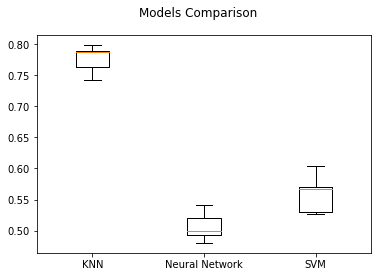

In [14]:
#Boxplot of different models

fig = plt.figure()
fig.suptitle('Models Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()